# Dynamic correlation functions

We will study the dynamics of a system composed of $N=8000$ particles under periodic boundary conditions and interacting via the Lennard-Jones potential
$$
u(r) = 4\epsilon \left[(\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6\right]
$$
which provides a good description of the properties of nobel gases (Ar, Xe, Ne). 

We will analyze trajectories obtained from molecular dynamics simulations performed in the microcanonical ensemble, at a density $\rho=0.85$ and several temperatures. As usual, energies and lengths are measured in units of $\epsilon$ and $\sigma$, respectively. The following values provide a good description of the properties of Argon using the Lennard-Jones potential: $\epsilon\approx 120 K$ and $\sigma \approx 3.4\times 10^{-10}m$.

We download the trajectory files (in compressed xyz format) and store them in the current directory. They are bigger than the ones we used to study the structure, so be patient

In [3]:
from atooms.core.utils import download

download('https://moodle2.units.it/pluginfile.php/404689/mod_folder/content/0/lammps-T0.7.xyz.gz', '.')
download('https://moodle2.units.it/pluginfile.php/404689/mod_folder/content/0/lammps-T4.0.xyz.gz', '.')

Let us have a quick look at the thermodynamic state of the system

In [4]:
from atooms.trajectory import TrajectoryXYZ

with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    system = th[0]
    print(system)
    print('T =', system.temperature)

system composed of N=8000 particles
with chemical composition C={'1': 8000}
with chemical concentration x={'1': 1.0}
enclosed in a cubic box at number density rho=0.850000

T = 4.047488007917088


The times at which the frames have been stored are spaced exponentially in time. This is a trick to cover both short and long time scales without occupying too much disk space.

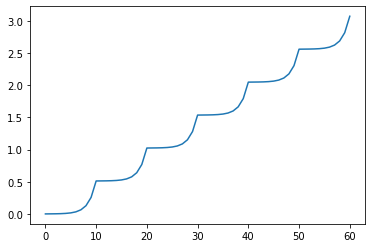

In [5]:
import matplotlib.pyplot as plt
plt.plot(th.times)

Finally, let's use some `postprocessing` tools to compute some dynamic correlation functions and plot them

In [6]:
import atooms.postprocessing as pp

with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    cfh = pp.MeanSquareDisplacement(th)
    cfh.compute()
    
with TrajectoryXYZ('lammps-T0.7.xyz.gz') as th:
    cfl = pp.MeanSquareDisplacement(th)
    cfl.compute()

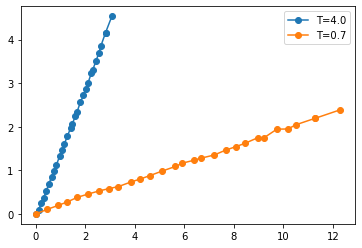

In [7]:
plt.plot(cfh.grid, cfh.value, '-o', label='T=4.0')
plt.plot(cfl.grid, cfl.value, '-o', label='T=0.7')
plt.legend()

In [8]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    cfh = pp.VelocityAutocorrelation(th, th.times[:20])
    cfh.compute()   
with TrajectoryXYZ('lammps-T0.7.xyz.gz') as th:
    cfl = pp.VelocityAutocorrelation(th, th.times[:20])
    cfl.compute()

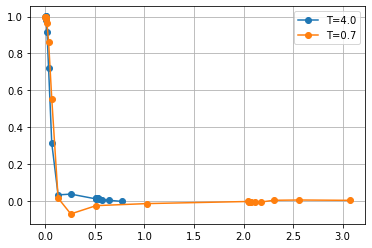

In [9]:
plt.plot(cfh.grid, cfh.value / cfh.value[0], '-o', label='T=4.0')
plt.plot(cfl.grid, cfl.value / cfl.value[0], '-o', label='T=0.7')
plt.legend()
plt.grid()

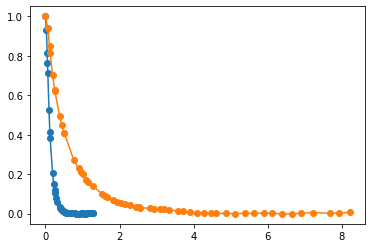

In [10]:
kvectors = list(range(1, 10))

# Note: cf.grid is a list containing the list of wave-vectors
# as first entry and the list of times as second entry 
# cf.value is now a list of the correlation functions at fixed k
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    cf1 = pp.SelfIntermediateScattering(th, kgrid=kvectors)
    cf1.compute()
    
with TrajectoryXYZ('lammps-T0.7.xyz.gz') as th:
    cf2 = pp.SelfIntermediateScattering(th, kgrid=kvectors)
    cf2.compute()
    
# We plot the F_s(k,t) for k=7 (the 6th entry of the time grid)
plt.plot(cf1.grid[1], cf1.value[6], '-o')    
plt.plot(cf2.grid[1], cf2.value[6], '-o')

Show the correlation using a log scale on the time axis: the time grid is exponentially spaced so that the the data points are evenly distributed (in time) when plotted in log scale.

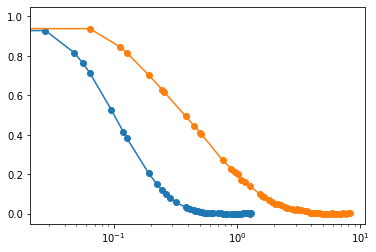

In [11]:
plt.semilogx(cf1.grid[1], cf1.value[6], '-o')
plt.semilogx(cf2.grid[1], cf2.value[6], '-o')

**Exercise 1**: *velocity correlations*
    
1) Check that the value of the unnormalized velocity correlation function at $t=0$ is consistent with an equilibrium state.

2) Focus on the initial decayt of the velocity autocorrelation function $Z(t)$. Fit the normalized function to the form $1-\frac{\Omega^2}{2}t^{2}$ and obtain a rough estimate of $\Omega$ (the so-called Einstein frequency), which gives the frequency at which a particle would oscillate around its position if the neighboring particles were frozen. How does it depend on temperature? Can you interpret this result? (you may want to have a look at the exercise 3.1 on the moodle page of the course).

3) The function $Z(t)$ decays to zero within a rather short time span. Estimate this time scale using physicalunits appropriate for Argon (you may need the mass of a argon atom).

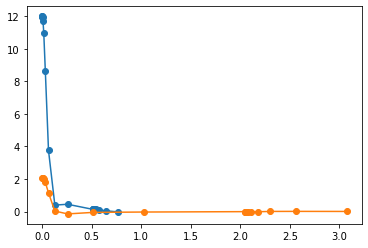

In [12]:
plt.plot(cfh.grid, cfh.value, '-o', label='T=4.0')
plt.plot(cfl.grid, cfl.value, '-o', label='T=0.7')

omega: 18.682323291486135


(-0.2, 1.5)

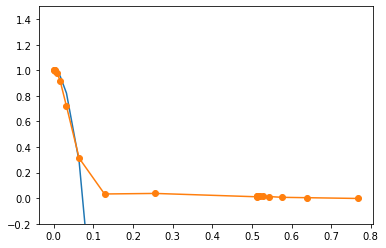

In [28]:
from scipy.optimize import curve_fit


def small_t(x, omega):
    data_list = []
    for value in x:
        data_list.append(1- omega**2*value**2/2)
    return data_list

popt, pcov = curve_fit(small_t, cfh.grid[:8], cfh.value[:8] / cfh.value[0])
print("omega:", *popt)
# Note the *popt syntax unpacks the array into individual variables
plt.plot(cfh.grid, small_t(cfh.grid, popt), '-')
plt.plot(cfh.grid, cfh.value / cfh.value[0], '-o', label='T=4.0')
plt.ylim([-0.2,1.5])

omega: 11.24383501128011


(-0.2, 1.5)

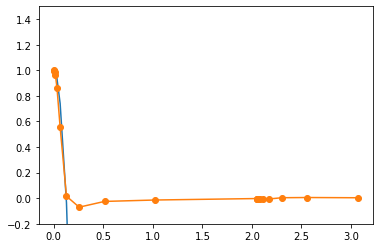

In [29]:
popt, pcov = curve_fit(small_t, cfl.grid[:7], cfl.value[:7] / cfl.value[0])
print("omega:", *popt)
# Note the *popt syntax unpacks the array into individual variables
plt.plot(cfl.grid, small_t(cfl.grid, popt), '-')
plt.plot(cfl.grid, cfl.value / cfl.value[0], '-o', label='T=0.7')
plt.ylim([-0.2,1.5])

La frequenza di Einstein è direttamente proporzionale alla temperatura.

**Exercise 2**: *Free particle regime*

Compare the exact expressions for $F_s(k,t)$ and $F(k,t)$ in free particle regime against the simulation data
- at fixed $k=7$ as a function of $t$
- at fixed $t=0.012$ as a function of $k$

As a function of t

In [45]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    fkt = pp.IntermediateScattering(th, nk=200, kgrid=[7])  
    fkt.compute()

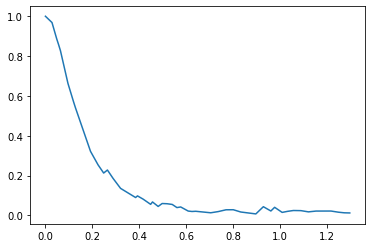

In [46]:
#print(fkt.grid, fkt.value)
plt.plot(fkt.grid[1], fkt.value[0])

In [47]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    fkt_self = pp.SelfIntermediateScattering(th, nk=200, kgrid=[7])
    fkt_self.compute()

[[7.006581727086921], [0.0, 0.028, 0.048, 0.056, 0.064, 0.096, 0.12, 0.128, 0.192, 0.224, 0.248, 0.264, 0.28800000000000003, 0.32, 0.384, 0.392, 0.41600000000000004, 0.448, 0.456, 0.48, 0.497, 0.518, 0.54, 0.56, 0.5760000000000001, 0.608, 0.624, 0.64, 0.704, 0.736, 0.769, 0.8, 0.8320000000000001, 0.896, 0.928, 0.96, 0.976, 1.008, 1.032, 1.056, 1.088, 1.12, 1.1480000000000001, 1.1520000000000001, 1.216, 1.248, 1.272, 1.296]] [[1.0, 0.9683714746429398, 0.8868466036490227, 0.8578081677966566, 0.8270926648467787, 0.6625912200467208, 0.5695438034864605, 0.5400686765709859, 0.3216319434553816, 0.2540136887923053, 0.21264820536128454, 0.22777139305827682, 0.1858634339877614, 0.1356361188123451, 0.08969784201044671, 0.0978754290536327, 0.0816326904550483, 0.055428785927341, 0.06743977209376037, 0.04490421349250748, 0.05955054826632932, 0.05850376869671245, 0.054942306686793764, 0.03920450912967685, 0.042295789031723256, 0.021721626212749253, 0.019626520086353808, 0.020625767503972357, 0.013084

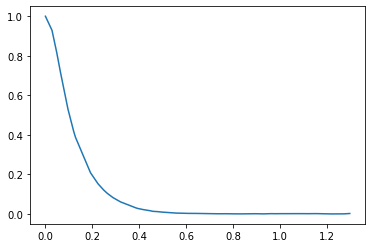

In [48]:
print(fkt.grid, fkt.value)
plt.plot(fkt_self.grid[1], fkt_self.value[0])

As a function of k

In [110]:
import numpy

def gaussian_k(k, t, a):
    data_list = []
    for vectors in k:
        data_list.append(numpy.exp(-a*(vectors*t)**2/6))
    return data_list

In [127]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    fkt = pp.SelfIntermediateScattering(th, nk=200, tgrid=[0.012], kgrid=[0, 10, 20, 30, 40, 50])  
    fkt.compute()
print(fkt.grid, fkt.value)

[[0.0, 9.996899941510355e+00, 19.994753924154764, 30.00607544067676, 40.00144435304719, 49.999506342977405], [0.0, 0.012]] [[1.0, 1.0], [1.0, 0.9718211107912408], [1.0, 0.8922371404655984], [1.0, 0.7736399659858189], [1.0, 0.6340223383582737], [1.0, 0.4909603164795006]]


In [128]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(gaussian_k, fkt.grid[0], [value[1] for value in fkt.value])

/tmp/ipykernel_6268/3813212266.py:6: RuntimeWarning: overflow encountered in exp
  data_list.append(numpy.exp(-a*(vectors*t)**2/6))


[[0.0, 9.996899941510355e+00, 19.994753924154764, 30.00607544067676, 40.00144435304719, 49.999506342977405], [0.0, 0.012]] [[1.0, 1.0], [1.0, 0.9718211107912408], [1.0, 0.8922371404655984], [1.0, 0.7736399659858189], [1.0, 0.6340223383582737], [1.0, 0.4909603164795006]]


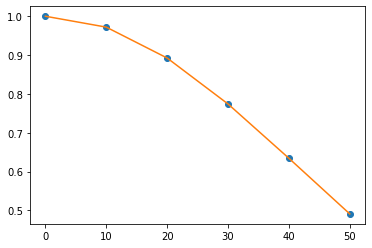

In [129]:
print(fkt.grid, fkt.value)
plt.plot(fkt.grid[0], [value[1] for value in fkt.value], 'o')
plt.plot(fkt.grid[0], gaussian_k(fkt.grid[0], *popt), '-')

**Exercise 3**: *Gaussian approximation*

1) Test the Gaussian approximation
$$
F_s(k,t) = \exp{\left(-\frac{1}{6} k^2 t\right)}
$$
by superposing the actual self intermediate scattering function to its approximation for selected values of the wave-vector $k$.

*Hint*: use a log scale of the time axis for better visualization.

2) Repeat the test for the lowest acceptable wave-vector, which can be selected by asking for a negative wave-vector (ex. -1) in  `kgrid`

In [60]:
import numpy

def gaussian_t(k, t):
    data_list = []
    for times in t:
        data_list.append(numpy.exp(-k**2*times/6))
    return data_list

In [62]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    fkt_self = pp.SelfIntermediateScattering(th, nk=200)
    fkt_self.compute()

[1.0, 0.9291380329569667, 0.8178433668426613, 0.7680040315561493, 0.7177487116949018, 0.5311486147576414, 0.4203094289398663, 0.38887348102834995, 0.20932403976049016, 0.1533145136566264, 0.12164328513089097, 0.10349666903232621, 0.08219034739833381, 0.06042526531745657, 0.030432124427684667, 0.02724931960557377, 0.021155268140553633, 0.015342491418314072, 0.012900019691667522, 0.011220869657150556, 0.009006458766100607, 0.007190837352214759, 0.005242854717436447, 0.0036461073002460767, 0.0032366951827368967, 0.0021622318425113035, 0.0020344943059228664, 0.0019615525228457295, 0.0005300742403854548, 3.084207523762596e-05, 0.0002055550003523009, -0.00032038612962429907, -0.00056243453002368, -0.00011992174402753565, -0.000713153670479248, 0.00020340529400850616, -0.00012889920840517777, 0.00048295542380030434, 0.000526384367435474, 0.00047938442838506615, 0.00024405304646419072, -0.0004340131067415684, -1.0613081252175e-05, 4.02981314650484e-05, -0.0009702344174973748, -0.00072697518966

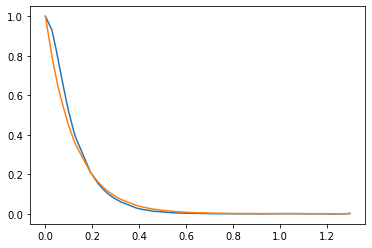

In [73]:
plt.plot(fkt_self.grid[1], fkt_self.value[6])
plt.plot(fkt_self.grid[1], gaussian_t(fkt_self.grid[0][6], fkt_self.grid[1]))

Tentativo con k negativo, ma kgrid non funziona

In [93]:
with TrajectoryXYZ('lammps-T4.0.xyz.gz') as th:
    fkt_self = pp.SelfIntermediateScattering(th, nk=200, kgrid=[-1])
    fkt_self.compute()

In [ ]:
plt.plot(fkt_self.grid[1], fkt_self.value[0])
plt.plot(fkt_self.grid[1], gaussian_t(0.3, fkt_self.grid[1]))